# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  

DO 12-17-2018  
Looking at different ethanol ratios

DO 12-19-2018  
Using measured metabolite data to further constrain the system


In [1]:
import numpy as np
from numpy import array, eye, log, zeros
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds, DEFAULT_BOUNDS
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import copy # for copying pp objects
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [2]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations. Choose column names to make it easy to 
    convert the dataframe back to a bounds object
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

atkDict = dict(zip(kt['ABBREVIATION'].values, kt['KEGG ID(S)'].values))
ktaDict = dict(zip(kt['KEGG ID(S)'].values, kt['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set pH and ionic strength

In [131]:
# need to declare pH and ionic strength constants at the beginning
# they are used in the make_pathway function
PH = 7.0
IS = 0.1

# load stoichiometric model from Excel file
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD2.xlsx', # using Satya's version
                         sheet_name = 'reactions')
# make list of flux sets from excel file column names
# all of the column names from 'ppi-pfk' to 'mal-gapn' inclusive
fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values 

# load bounds information from the model
boundsDf = pd.read_excel('cth_thermo_model_DO_SD2.xlsx', # using Satya's version
                         sheet_name = 'metabolite_bounds')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,CBtx,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,1,1,1,1,1,1,1,1,1,1
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1,1,1,1,1,1,0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0,0,0,0,0,0,0,0,1
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1,1,1,1,1,1,0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0,0,0,0,0,0,0,0,2


In [71]:
def make_pathway(fluxSet, allRxnDf):
    """
    Given a fluxSet name, return the parsed pathway object
    
    Args:
       fluxSet: is the name of a column in the Excel model file
       allRxnDf: a dataframe with the model reactions
    """
    # choose a flux set, and drop all of the zero-flux reactions
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
                                                                     # processing
    #selectedRxnDf
    # parse the KeggFormula column to create eQuilibrator Reaction objects
    # create reaction list
    reactions = []
    for i, row in selectedRxnDf.iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))

    # create flux list
    fluxes = selectedRxnDf['flux'].values

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)

    # set up the model
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes, 
                 pH = PH, ionic_strength = IS, bounds = None)
    return pp

## Get measured metabolite data and use it to set bounds
* There are several datasets to choose from. For now, I'm going to focus on dataset 2, which we think is the highest quality.
* Note that the originaly analysis Josh did was based on dataset 1, which has more timepoints, but the sampling was done aerobically instead of anaerobically

In [6]:
# get processed metabolite data
metDf = pd.read_excel(r'metabolite_data/lt_dataset2_quantified.xlsx')

# Translate metabolite names to KEGG IDs using KNOWNS csv file
# The plaintext names of the compounds are slightly different from whats in the KEGG_SEED file
# Fortunately, the file also has KEGG IDs
stdsDf = pd.read_csv('metabolite_data/KNOWNS-Dan121218v2.csv')
stdsDf.set_index('compound', inplace = True)

# map KEGG IDs to the metDf dataframe
metDf['KEGG_ID'] = metDf['compound'].apply(lambda x: stdsDf.loc[x, 'id'])

# Fix ethanol data so that it's similar to other metabolites
etohGtoM = 46.07
etDf = metDf.loc[:, ('ID', 'Sample', 'Ethanol', 'Timepoint', 'Time (h)','Replicate', ' EtOH concentraion (g/L)')] # watch out for space in front of EtOH column name
etDf = etDf.drop_duplicates()
etDf['KEGG_ID'] = 'C00469' # KEGG ID for ethanol
etDf['compound'] = 'ethanol'
etDf['amount_int'] = etDf[' EtOH concentraion (g/L)']*(1/etohGtoM)*1e6 # ethanol concentration in the cells is the same as the concentration in the bulk solution, units of uM

# append ethanol data to existing metabolite dataframe
metDf2 = metDf.append(etDf, sort = False)
metDf2[:5]

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,sample volume ml,ODxml,compound,peakAreaTop,amount,amount_int,KEGG_ID
0,1,A,+EtOH,2,2.016667,1,A1_1,5,0.2,10.0,2.0,3PG,8703433.00,3.400159,217.958918,C00197
1,1,A,+EtOH,2,2.016667,1,A1_1,5,0.2,10.0,2.0,Acetyl-CoA,1346292.12,6.497535,416.508650,C00024
2,1,A,+EtOH,2,2.016667,1,A1_1,5,0.2,10.0,2.0,ADP,988751.06,1.833074,117.504732,C00008
3,1,A,+EtOH,2,2.016667,1,A1_1,5,0.2,10.0,2.0,AMP,9313822.00,12.582890,806.595532,C00020
4,1,A,+EtOH,2,2.016667,1,A1_1,5,0.2,10.0,2.0,ATP,623393.06,0.534866,34.286253,C00002


In [ ]:
# stopped here 2:03 pm 12-20-2018

In [126]:
# sort the samples in an order that will be useful for subsequent visualization
sampleDf = metDf2.loc[:,'ID':'OD'].drop_duplicates()
sampleDf.dropna(axis = 'rows', inplace = True) # drop NaN rows that were added due to ethanol changes
sampleDf.sort_values(['Sample', 'Replicate', 'Timepoint'], inplace = True)

# make new colums
sampleDf['graphName'] = ''
for idx, row in sampleDf.iterrows():
    row['graphName'] = row['Maven filename'] + ' et=' + str(row[' EtOH concentraion (g/L)'])
    
sampleDf

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,graphName
0,1,A,+EtOH,2,2.016667,1,A1_1,5,0.20,
46,3,A,+EtOH,5,3.750000,1,A2_1,20,0.27,
91,5,A,+EtOH,9,5.916667,1,A3_1,40,0.29,
23,2,A,+EtOH,2,2.016667,2,A1_2,5,0.20,
69,4,A,+EtOH,5,3.750000,2,A2_2,20,0.27,
113,6,A,+EtOH,9,5.916667,2,A3_2,40,0.29,
136,7,B,no EtOH,2,2.016667,1,B1_1,5,0.21,
181,9,B,no EtOH,5,3.750000,1,B2_1,20,0.58,
224,11,B,no EtOH,9,5.916667,1,B3_1,40,1.40,
158,8,B,no EtOH,2,2.016667,2,B1_2,5,0.21,


In [51]:
# generate bounds objects for each condition within a dataset
def generate_bounds(metaboliteDf, errorFactor = 1, metsToExclude = []):
    """
    Given a dataframe with metabolite values, generate a new bounds object
    for each ID group in the metabolite dataframe
    
    Args:
        metaboliteDf: a dataframe with the following columns
           'ID' - each metabolite group has an ID, and represents a unique combination of Sample, Timepoint and Replicate
           'amount_int' - intracellular metabolite concentration in uM
        errorFactor: factor by which upper and lower bounds are adjusted to account for uncertainty
        metsToExclude: a list of KEGG IDs to skip over when setting bounds
                       for example, metabolites whose concentration data we
                       don't trust
    """

    EQ_BOUNDS = Bounds.from_csv_filename('data/cofactors.csv') # need to decide if I want to adjust the default bounds to the max and min values from the metabolite dataframe
    boundsList = []
    g = metaboliteDf.groupby('ID') # group the metabolite dataframe by the ID column
    idList = list(g.groups.keys()) # all of the keys in the group
    for name, group in g:
        newBounds = EQ_BOUNDS.Copy()
        for idx, row in group.iterrows():
            cid = row['KEGG_ID']
            amt = row['amount_int']*1e-6 # amount is in uM, need to convert to M
            if cid not in metsToExclude:
                newBounds.SetBounds(cid, amt/errorFactor, amt*errorFactor)
        boundsList.append(newBounds)

    # make a new dataframe with the ID and bounds object for each group
    df = pd.DataFrame({'ID': idList, 'Bounds':boundsList})
    df.set_index('ID', inplace = True)
    return df


In [55]:
# set bounds for each condition within a dataset
metaboliteDf = metDf2
errorFactor = 2 # factor by which upper and lower bounds are adjusted to account for uncertainty
metsToExclude = ['C00197'] # for testing this function

myBoundsDf = set_model_bounds(metDf2, errorFactor)
myBoundsDf

,Bounds
ID,
1,<equilibrator_api.bounds.Bounds object at 0x00...
2,<equilibrator_api.bounds.Bounds object at 0x00...
3,<equilibrator_api.bounds.Bounds object at 0x00...
4,<equilibrator_api.bounds.Bounds object at 0x00...
5,<equilibrator_api.bounds.Bounds object at 0x00...
6,<equilibrator_api.bounds.Bounds object at 0x00...
7,<equilibrator_api.bounds.Bounds object at 0x00...
8,<equilibrator_api.bounds.Bounds object at 0x00...
9,<equilibrator_api.bounds.Bounds object at 0x00...


In [66]:
# checking the bounds objects to make sure things are set up the way I want
myMetList = metDf2.KEGG_ID.unique()
b = myBoundsDf.loc[7, 'Bounds']
bounds_to_df(myMetList, b)

,Compound:Identifiers:kegg.compound,Name,Concentration:Max,Concentration:Min
0,C00197,3pg,0.000348,0.000087
1,C00024,accoa,0.000073,0.000018
2,C00008,adp,0.000467,0.000117
3,C00020,amp,0.001641,0.000410
4,C00002,atp,0.000218,0.000055
5,C00185,cellb,0.044617,0.011154
6,C00010,coa,0.000133,0.000033
7,C00111,dhap,0.000008,0.000002
8,C00354,fdp,0.000025,0.000006
9,C00085,f6p,0.003785,0.000946


In [117]:
def get_model_description(pp):
    """
    Given an equilibrator-api pathway object, determine the net reaction 
    and dG0 and format into a string
    """
    rm = ReactionMatcher()
    dG0p = pp.net_reaction().dG0_prime() # float
    rnxTxt = rm.write_text_formula(pp.net_reaction())
    netRxnTxt = '∆G0={0:.2f}\n{1}'.format(dG0p, rnxTxt)
    return netRxnTxt

## Set up plotting

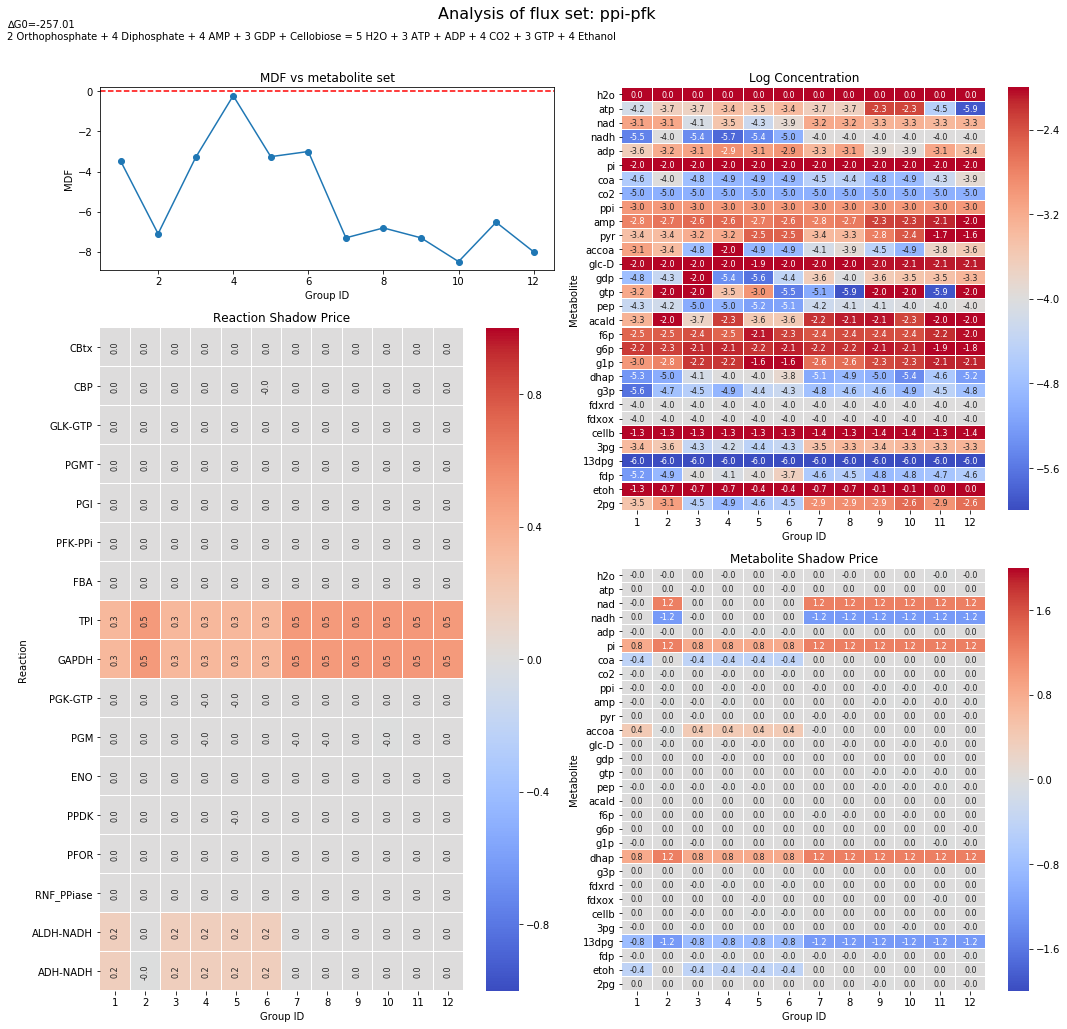

In [109]:
make_plots('ppi-pfk', mdf_values, allBoundsSets.index, compDf, rxnDf, netRxns)

In [108]:
# function for plotting the results
def make_plots(fluxSet,  mdf_values, groupId, compDf, rxnDf, netRxns, savePdf = False):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure( figsize=(15,15))
    fig.suptitle('Analysis of flux set: {}'.format(fluxSet), fontsize=16, )
    plt.figtext(x=0, y=0.95, s=netRxns[fluxSet], fontsize=10, wrap = True)
    gs = GridSpec(4,2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0]) # for MDF plot
    ax2 = fig.add_subplot(gs[1:, 0]) # for shadow price plot
    ax3 = fig.add_subplot(gs[:2, 1]) # metabolite concentrations
    ax4 = fig.add_subplot(gs[2:, 1]) # metabolite shadow prices

    # MDF plot
    ax1.plot(groupId, mdf_values, '-o')
    ax1.set_title('MDF vs metabolite set')
    ax1.set_ylabel('MDF')
    ax1.set_xlabel('Group ID')
    ax1.axhline(y=0, color='r', linestyle='--')
    
    # reaction shadow price plot
    df = rxnDf.loc[:, 'shadow_price']
    sns.heatmap(df, linewidths = 0.05, ax = ax2, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8, 'rotation':90}, vmin=-1, vmax=1)
    ax2.set_title('Reaction Shadow Price')
    ax2.set_ylabel('Reaction')
    ax2.set_xlabel('Group ID')
    
    # concentration plot
    df = compDf.loc[:, 'concentration'].apply(np.log10)
    sns.heatmap(df, ax = ax3, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-6, vmax=-2)
    ax3.set_title('Log Concentration')
    ax3.set_ylabel('Metabolite')
    ax3.set_xlabel('Group ID')

    # metabolite shadow price plot
    df = compDf.loc[:, 'shadow_price'] #.apply(np.log10)
    sns.heatmap(df, ax = ax4, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-2, vmax=2)
    ax4.set_title('Metabolite Shadow Price')
    ax4.set_ylabel('Metabolite')
    ax4.set_xlabel('Group ID')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    # save the results as a PDF if that flag is set to True
    if savePdf:
        plt.savefig('etoh_analysis_{}.pdf'.format(fluxSet), bbox_inches = "tight")

## Analyze all flux sets




********* Working on flux set ppi-pfk ************
  *** Working on metabolite set 1 ***


C:\Users\Dan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


  *** Working on metabolite set 2 ***
  *** Working on metabolite set 3 ***
  *** Working on metabolite set 4 ***
  *** Working on metabolite set 5 ***


KeyboardInterrupt: 

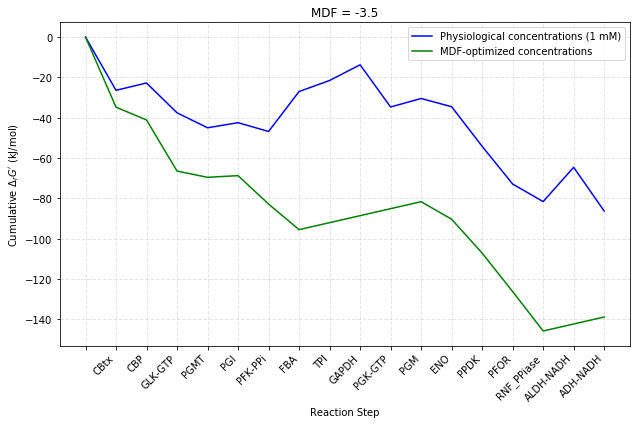

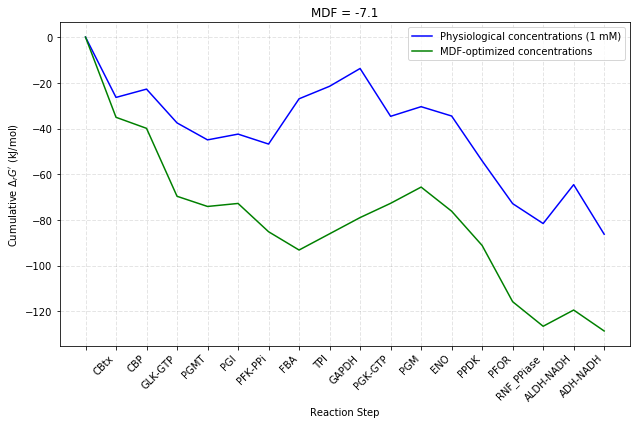

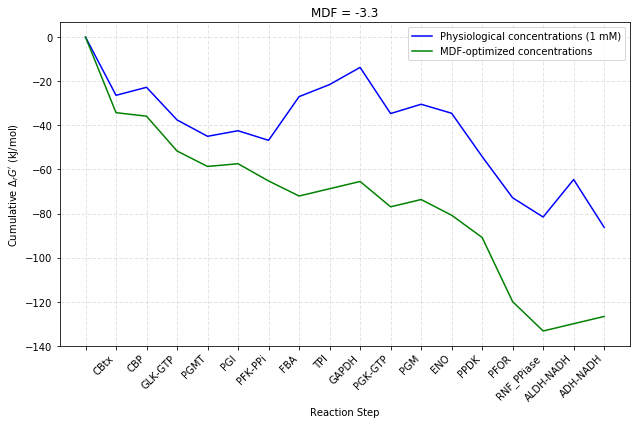

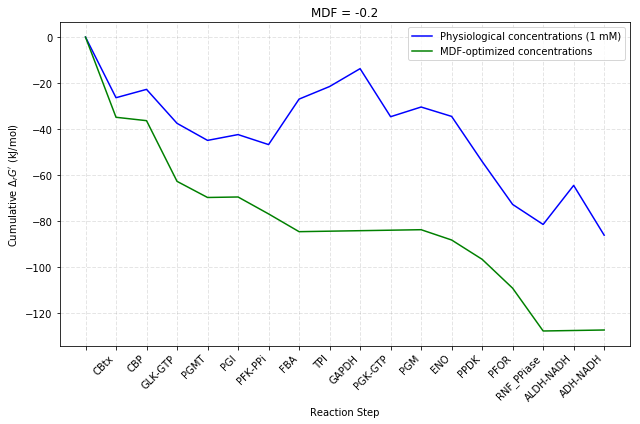

In [132]:
rm = ReactionMatcher() # for translating net reactions to plaintext
fluxSets = ['ppi-pfk'] # for testing, when I don't want to run through all of the flux sets
#fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values
netRxns = {} # dictionary to hold net reaction strings for each flux set

allBoundsSets = set_model_bounds(metDf2, errorFactor = 2)

for fluxSet in fluxSets:
    print('\n\n\n********* Working on flux set {} ************'.format(fluxSet))
    pp = make_pathway(fluxSet, allRxnDf)
    netRxns[fluxSet] = get_model_description(pp)
    
    # calculate the min-max driving force for different ethanol concentrations
    mdf_result = [] # store list of mdf_result objects, in case we want to inspect them later
    mdf_values = [] # store MDF values for making MDF vs. ethanol plot
    compoundDfList = [] # hold report_compounds dataframes
    rxnDfList = [] # hold report_reactions dataframes
    
    for idx, row in allBoundsSets.iterrows():
        print('  *** Working on metabolite set {} ***'.format(idx))
        pp.bounds = row['Bounds']
        result = pp.calc_mdf()
        result.mdf_plot.show() # show MDF vs. reaction plot
        mdf_result.append(result)
        mdf_values.append(result.mdf)

        # clean up dataframe for compounds
        df = pd.DataFrame(result.report_compounds)
        df['mets'] = df['compound'].map(ktaDict)
        df.set_index('mets', drop = True, inplace = True)
        mi = pd.MultiIndex.from_product([[idx], df.columns], names = ['ID', 'data'])
        df.columns = mi
        compoundDfList.append(df)
        
        # clean up dataframe for reactions
        df2 = pd.DataFrame(result.report_reactions)
        rxnIds = list(r.reaction_id for r in pp.reactions)
        df2['name'] = rxnIds
        df2.set_index('name', drop = True, inplace = True)
        mi2 = pd.MultiIndex.from_product([[idx], df2.columns], names = ['ID', 'data'])
        df2.columns = mi2
        rxnDfList.append(df2)
    
    # merge all of the report_compound dataframes into one big one
    # arrange the compound results in a dataframe to make plotting easy
    compDf = pd.concat(compoundDfList, axis=1)
    compDf = compDf.swaplevel(axis = 'columns')
    
    rxnDf = pd.concat(rxnDfList, axis=1)
    rxnDf = rxnDf.swaplevel(axis = 'columns')

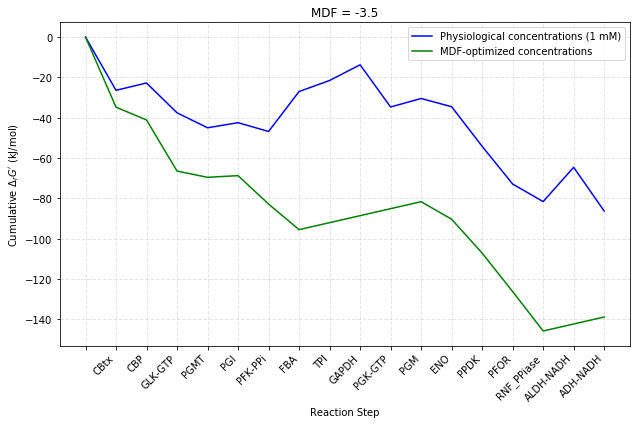

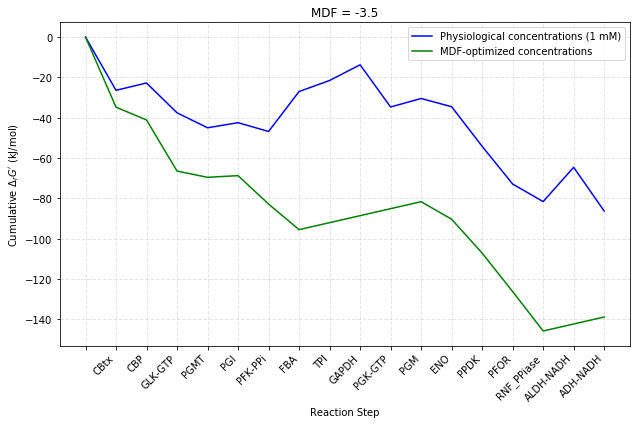

In [130]:
mdf_result[0].mdf_plot

In [ ]:
# checking adenylate charge
df2 = df.loc[:,8.0]
atp = df2.loc['atp', 'concentration']
adp = df2.loc['adp', 'concentration']
amp = df2.loc['amp', 'concentration']

atpCharge = (atp + 0.5*adp)/(atp+adp+amp)
print(atp)
print(adp)
print(amp)
print(atpCharge)